# Tutorial for MIRI Coronagraphy Reduction with spaceKLIP

---

In this notebook, you will learn how to reduce MIRI coronagraphy data from the JWST ERS program on Direct Observations of Exoplanetary Systems ([Program 1386](https://www.stsci.edu/jwst/science-execution/program-information?id=1386)), with a focus on the exoplanet HIP 65426 b. This tutorial guides you step-by-step through the data reduction process using the spaceKLIP pipeline, offering a clear and concise workflow tailored for effective high-contrast imaging analysis. By the end of this notebook, you will have gained hands-on experience with the tools and techniques necessary for reducing MIRI coronagraphic data, preparing you to apply these methods to other similar datasets.


<div class="alert alert-warning">
    
**Related Tutorials and Further Information**: This notebook is intentionally very similar to the ["Tutorial for NIRCam Coronagraphy Reduction with spaceKLIP"](https://spaceklip.readthedocs.io/en/latest/tutorials/tutorial_NIRCam_reductions.html) notebook. Subsequent analyses will be done in the ["Tutorial for MIRI Post-Pipeline Contrast Analyses Using spaceKLIP"](https://spaceklip.readthedocs.io/en/latest/tutorials/tutorial_MIRI_contrast_analyses.html) notebook. For complete interactive plotting capabilities, download the notebook and execute it locally.
</div>

<div class="alert alert-info">
    
**MIRI-specific Information**: Steps and information specific to MIRI are called out in blue.</div>

<h1 style="font-size: 24px;">Table of Contents</h1>

* [1. Introduction](#Introduction)
* [2. Setup and Imports](#Setup-and-Imports)
* [3. Download the Data](#Precursor:-Download-the-Data)
* [4. Stage 1 Reductions](#Stage-1-Reductions)
    * [4.1 Index Files into Database for Stage 1](#Index-Files-into-Database-for-Stage-1)
    * [4.2 Run Stage 1 Pipeline](#Run-Stage-1-Pipeline)
    * [4.3 Display Stage 1 Reductions](#Display-Stage-1-Reductions)
* [5. Stage 2 Reductions](#Stage-2-Reductions)
    * [5.1 Re-read Stage 1 Outputs into Database](#Optional:-Re-read-Stage-1-Outputs-into-Database)
    * [5.2 Run Stage 2 Pipeline](#Run-Stage-2-Pipeline)
    * [5.3 Display Stage 2 Reductions](#Display-Stage-2-Reductions)
* [6. Stage 3 reductions: Preparations for PSF subtraction](#Stage-3-Reductions:-Preparations-for-PSF-Subtraction
)
    * [6.1 Re-read Stage 2 Outputs into Database](#Optional:-Re-read-Stage-2-Outputs-into-Database)
    * [6.2 Using spaceKLIP ImageTools](#Using-spaceKLIP-ImageTools)
    * [6.3 Crop the Frames](#Crop-the-Frames)  
    * [6.4 Find and Repair Bad Pixels](#Find-and-Repair-Bad-Pixels)
    * [6.5 Remove Background](#Remove-Background)
    * [6.5 Finish Pixel Cleanup](#Finish-Pixel-Cleanup)
    * [6.6 Improve PSF Centering and Alignment](#Improve-PSF-Centering-and-Alignment)
        * [6.6.1 Update MIRI Offset Metadata](#Update-MIRI-Offset-Metadata)
        * [6.6.2 Calculate Recentering Shifts](#Calculate-Recentering-Shifts)
        * [6.6.3 Calculate Alignment Shifts](#Calculate-Alignment-Shifts)
        * [6.6.4 Shift Frames](#Shift-Frames)
    * [6.7 Pad Empty Space Around Frames](#Pad-Empty-Space-Around-Frames)
    * [6.8 Display the Cleaned Datasets](#Display-the-Cleaned-Datasets)
* [7. Stage 3 Reductions: KLIP](#Stage-3-Reductions:-KLIP)
    * [7.1 PSF Subtraction: Option Using pyKLIP](#PSF-Subtraction:-Option-Using-pyKLIP)
    * [7.2 Re-read Stage 3 Outputs into Database](#Optional:-Re-read-Stage-3-Outputs-into-Database)

---

## Introduction

A comprehensive introduction to High-Contrast Imaging (HCI) techniques and challenges, including differential imaging methods and point spread function (PSF) subtraction algorithms, can be found in the ["Tutorial for NIRCam Coronagraphy Reduction with spaceKLIP"](https://spaceklip.readthedocs.io/en/latest/tutorials/tutorial_NIRCam_reductions.html) notebook. In this notebook, we introduce the coronagraphic capabilities of the Mid-Infrared Instrument (MIRI) aboard the James Webb Space Telescope (JWST).

MIRI offers coronagraphic imaging with four individual coronagraphs—one [Lyot-type coronagraph](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-instrumentation/miri-coronagraphs#MIRICoronagraphs-lyot&gsc.tab=0:~:text=al.%20(2022).-,Lyot%20coronagraph,-The%20Lyot%20coronagraph) and three [4-quadrant phase-mask (4QPM) coronagraphs](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-instrumentation/miri-coronagraphs#MIRICoronagraphs-lyot&gsc.tab=0:~:text=4%2Dquadrant%20phase%20mask%20(4QPMs)%20coronagraphs%C2%A0)—that facilitate HCI at wavelengths of 10–23 µm.

* **Four-Quadrant Phase Mask (FQPM) Coronagraph**: Unlike the occulting mask used in a Lyot-type coronagraph, an FQPM is a four-quant transparent mask centered on the star. The FQPM introduces a 180° phase shift in the light transmitted through two diagonal quadrants. This phase manipulation results in destructive interference at the star’s position, effectively canceling its light and allowing off-axis sources (companions) to pass through with minimal distortion. MIRI’s FQPM coronagraphs provide the smallest possible inner working angle (IWA) of ~1 λ/D at 10-16 μm, making it particularly effective for detecting objects very close to the star. However, each operates over a narrow wavelength range.
  
* **Lyot Coronagraph**: MIRI and NIRCam Lyot-type coronagraphs have similar designs, featuring two binary masks: the occulter and the Lyot stop. The occulter is positioned at the initial focal plane and blocks light from the central star, allowing light from companions to pass through. The Lyot stop in the re-imaged pupil plane blocks residual diffracted light from the star. The occulter radius defines the IWA, MIRI’s being ~3.3 λ/D at 23 µm, and is particularly useful for investigating structures and diffuse emissions near bright sources, such as protoplanetary and debris disks.


While coronagraphs block most of the starlight, there is some star leakage (or diffracted starlight) that propagates to the detector and results in a residual starlight "speckle" pattern or static wavefront errors that require additional post-processing and imaging techniques to remove, which we will explore in the remainder of this notebook using the [spaceKLIP data reduction pipeline](https://spaceklip.readthedocs.io/en/latest/).


---

## Setup and Imports

In [1]:
import os, time
import glob
import numpy as np
import subprocess

import spaceKLIP

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

from astropy.io import fits

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
[spaceKLIP.utils:WARNING] Using SVO Filter Profile Service timed out. Using WebbPSF instead.


In [2]:
#ADDED TO CHANGE THE PATH
os.environ["CRDS_PATH"] = "/home/cysil/JWST/projects/Coronography/MIRI/crds_cache"
print(os.environ["CRDS_PATH"])

/home/cysil/JWST/projects/Coronography/MIRI/crds_cache


Note that currently the import of `webbpsf_ext` has a side effect of configuring extra verbose logging. We're not interested in that logging text, so let's quiet it. 


In [3]:
import webbpsf_ext
webbpsf_ext.setup_logging('WARN', verbose=False)

---

In [4]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

## Precursor: Download the Data

If you already have a copy of this data, you can adjust the paths below accordingly. In this notebook, we assume you don't have the data yet, so let's download it here.

We will use the `jwst_mast_query` [package](https://github.com/spacetelescope/jwst_mast_query) for this. Consult the package's documentation for more details.

We'll download all the uncalibrated raw data (`uncal.fits`), as we will use spaceKLIP to invoke the [JWST pipeline](https://github.com/spacetelescope/jwst) with customized options and extra steps optimized for coronagraphy.

In [5]:
data_root = 'data_miri_hd65426'

In [6]:
# Make subdirectories to put the data in.

#os.makedirs(data_root, exist_ok=True)
#os.makedirs(os.path.join(data_root, 'uncal'), exist_ok=True)

# Invoke the download.
#download_cmd = (
#    "yes | jwst_download.py --propID 1386 -i miri -l 1200 "
#    "--obsnums 4 5 6 7 8 9 28 29 30 31 "
#    "--outsubdir data_miri_hd65426/uncal --skip_propID2outsubdir "
#    "-f uncal --date_select 59371.0+"
#)

#process=subprocess.Popen(download_cmd, shell=True,
#                         stdout=subprocess.PIPE,
#                         stderr=subprocess.PIPE)
#stdout, stderr = process.communicate()

# Uncomment to print the download log and any errors.
#print(stdout.decode())
#print(stderr.decode())

---

## Stage 1 Reductions

### Index Files into Database for Stage 1
SpaceKLIP relies on a `Database` class to track observations, data files, and the relationships between them. 

We begin by creating a database and reading files into it. 

For this tutorial, let's only reduce one filter's worth of data. 

In [7]:
#program = 1386   # Define program.
#filt = 'F1550C'  # Set to None to disable filter selection and load all filters.

In [8]:
# Initialize spaceKLIP database.
#database = spaceKLIP.database.create_database(input_dir=os.path.join(data_root, 'uncal'),
#                                              output_dir=data_root,
#                                              assoc_using_targname=False,
#                                              filt=filt,
#                                              pid=program)

The above is a bit verbose and can be difficult for a human to parse; let's ask the database to summarize what it contains:

In [9]:
#database.summarize()

Above, you should notice three types of files contained in the database:

* **Science** (`SCI`): These files hold the primary coronagraphic observational data of the target—in this case, the exoplanet host star HIP 65426. This program also conducted coronagraphic observations at two separate roll angles, which refer to specific pointing/orientation of the telescope. Hence, there are two `SCI` files.
* **Reference** `REF`: These files contain the reference PSF observations of other stars—in this case, of the nearby star HIP 68245. There are nine `REF` files, one for each dithered exposure.
* **Background** (`SCI_BG` and `REF_BG`): These files contain the background data for each roll, corresponding to both the science and reference targets.

---

### Run Stage 1 Pipeline

The `Coron1Pipeline` (`calwebb_coron1`[↘️](https://spaceklip.readthedocs.io/en/latest/stage1.html)) in spaceKLIP is a custom subclass of the JWST Stage 1 pipeline, `Detector1Pipeline` (`calwebb_detector1`[↘️](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1)). It is specifically designed to optimize the processing of high-contrast imaging data typical of coronagraphic observations. This pipeline applies group-by-group detector-level corrections, followed by ramp fitting, to the raw, uncalibrated data (`uncal.fits`[↘️](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#:~:text=g.%20%E2%80%9Cjw80600012001_02101_00003_mirimage_ramp.fits%E2%80%9D.-,Inputs,-%EF%83%81)). The output is calibrated count rate products (`rateints.fits`[↘️](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#:~:text=be%20ImageModel.-,3D%20countrate%20product,%EF%83%81,-Data%20model)).

The `Coron1Pipeline` performs the following steps for MIRI. Custom spaceKLIP steps and parameters are marked with stars (⭐). Click on the steps with the attached (ReadtheDocs 📄) links to learn more about specific JWST pipeline steps.


> * `group_scale` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/group_scale/description.html))</span>
> * `dq_init`  <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/dq_init/description.html))</span>
> * `saturation` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/saturation/description.html))</span>    
>    *  `flag_rcsat`: Flag high dark current RC pixels as saturated? (Default: False).    
>    *  `grow_diagonal`: Flag diagonal neighboring pixels (or only bottom/top/left/right)? (Default: True).
>    * `n_pix_grow_sat` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/saturation/arguments.html))</span>
> * `ipc` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/ipc/description.html))</span>
> * `firstframe` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/firstframe/description.html))</span>
> * `lastframe` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/lastframe/description.html))</span>
> * `reset` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/reset/description.html))</span>
> * `linearity` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/linearity/description.html))</span>     
> * `rscd` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/rscd/description.html))</span>
> * `dark_current` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/dark_current/description.html))</span>
> * `refpix` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/refpix/index.html))</span>
>    * `odd_even_columns` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/refpix/arguments.html#:~:text=%2D%2D-,odd_even_columns,-If%20the%20odd_even_columns))</span>
>    * ⭐ `nlower`, `nupper`, `nleft`, `nright`: Number of pixels around edges to use as pseudo-refpix in NIRCam subarrays (Default: 4).   
>    * ⭐ `nrow_off`, `ncol_off`: Offset the reference pixel region from the top/bottom and left/right edges of the frame (Default: 0).
> * `jump` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/description.html))</span>
>    * `rejection_threshold` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html#:~:text=%2D%2D-,rejection_threshold,-%3A%20A%20floating%2Dpoint))</span> , `three_group_rejection_threshold` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html#:~:text=three_group_rejection_threshold))</span>,
>    * `four_group_rejection_threshold` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html#:~:text=four_group_rejection_threshold))</span> , `maximum_cores` <span style="font-size: 8px;">([ReadtheDocs📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html#:~:text=%2D%2D-,maximum_cores,-%3A%20The%20number%20of))</span>
> * `ramp_fit` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/ramp_fitting/description.html))</span>
>    * ⭐ `save_calibrated_ramp`: Save the calibrated ramp? The default is False.
> * `gain_scale` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/gain_scale/description.html))</span>


The following cell will run the `Coron1Pipeline` for all input data in the spaceKLIP database, saving the output to a subdirectory named `stage1`. This can take a long time to run, so be patient. 

In [10]:
#spaceKLIP.coron1pipeline.run_obs(database=database,
#                       steps={'group_scale': {'skip': False},
#                              'dq_init': {'skip': False, 'save_results':False},
#                              'saturation': {'n_pix_grow_sat': 1,
#                                             'grow_diagonal': False},
#                              'ipc': {'skip': True},
#                              'firstframe': {'skip': False},
#                              'lastframe': {'skip': False},
#                              'reset': {'skip': False},
#                              'linearity': {'skip': False},
#                              'rscd': {'skip': False},
#                              'dark_current': {'skip': True},
#                              'refpix': {'skip': False,
#                                         'odd_even_columns': True,
#                                         'odd_even_rows': True,
#                                         'nlower': 0,
#                                         'nupper': 0,
#                                         'nleft': 0,
#                                         'nright': 0,
#                                         'nrow_off': 0,
#                                         'ncol_off': 0},
#                              'jump': {'rejection_threshold': 8.,
#                                       'three_group_rejection_threshold': 8.,
#                                       'four_group_rejection_threshold': 8.,
#                                       'maximum_cores': 'all'},
#                              'ramp_fit': {'save_calibrated_ramp': False,
#                                           'maximum_cores': 'all'},
#                              'gain_scale': {'skip': False}},
#                       subdir='stage1')

We can now examine the updated database, which shows that all available files for each filter have been processed to Stage 1.

**Note**: The Stage 0 files are automatically removed from the database since there is no further processing required for them. However, the files remain on disk.


In [11]:
#database.summarize()

---

### Display Stage 1 Reductions

Let's examine the science and reference PSF data in the F1550C filter we processed through the `Coron1Pipeline`. You can use the built-in plotting function `spaceKLIP.plotting.display_coron_dataset` to display the images by passing the database object to the function. Each image includes annotations, with pixels marked as `DO_NOT_USE` in the data quality (DQ) extension highlighted in orange. Additionally, the plotting function allows you to restrict the display to filter specific data and save the images. The `restrict_to` parameter can be a simple string that filters by matching keys in the database or a dictionary that applies filters based on specific columns in the database table. The images will be saved as a PDF file to the current working directory by default or to a specified path if provided by the user passed to the `save_filename` keyword argument. There are also additional parameters, such as `vmin`, `vmax`, and `stretch`, that allow you to adjust the visualization settings for image normalization.

To browse through the files in the database interactively, set `interactive=True`. Doing this will enable a slider to flip through the images. To generate and save static plots in a PDF, set `interactive=False`.


In [12]:
#spaceKLIP.plotting.display_coron_dataset(
#    database,
#    restrict_to={
#        'FILTER': filt,  # Sort by filter.
#        'TYPE': ['SCI']  # Sort by file type SCI/REF.
#    },
#    interactive=True,  # Static or interactive plots?
#    zoom_center=3,  # Optional zoom factor; set to None to disable.
    # vmin=3, vmax=500,  # Define the min/max values for consistent image scaling.
#    save_filename=f'{data_root}/plots_{filt}_stage1.pdf'  # Save plots to PDF.
#)

**Note:** The leftmost four columns are reference pixels. The adjacent orange columns contain a mix of `NON_SCIENCE` pixels and those flagged as `DO_NOT_USE` by the MIRI bad pixel mask during the `dq_init` step. Before PSF subtraction, we will crop these images to retain only the coronagraphic data. Also the PSF may be difficult to see at this stage, but will become more visible after the background is subtracted in a later step.

---

## Stage 2 Reductions

### Optional: Re-read Stage 1 Outputs into Database 

This shows how you can start re-reductions at this stage in the processing, once the previous steps have been completed. You might want to re-read the data if, for example, you have been provided with files that have already been processed through Stage 1 but require further reductions.

In [13]:
program = 1386   # Define program.
filt = 'F1550C'  # Set to None to disable filter selection and load all filters.

In [14]:
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'stage1'),
                                    file_type='rateints.fits',
                                    output_dir=data_root,
                                    assoc_using_targname=False,
                                    filt=filt,
                                    pid=program)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
 TYPE  EXP_TYPE DATAMODL TELESCOP ... CENTER_MASK      ROLL_REF      BLURFWHM
------ -------- -------- -------- ... ----------- ------------------ --------
   SCI MIR_4QPM   STAGE1     JWST ...   [0.0 0.0] 108.17107381748745      nan
   SCI MIR_4QPM   STAGE1     JWST ...   [0.0 0.0] 117.54983150698699      nan
SCI_BG MIR_4QPM   STAGE1     JWST ...   [0.0 0.0] 112.74286239818893      nan
SCI_BG MIR_4QPM   STAGE1     JWST ...   [0.0 0.0] 112.74285728609199      nan
REF_BG MIR_4QPM   STAGE1     JWST ...   [0.0 0.0] 112.79986264216615      nan
REF_BG MIR_4QPM   STAGE1     JWST ...   [0.0 0.0] 112.79993618079723      nan
   REF MIR_4QPM   STAGE1     JWST ...   [0.0 0.0]  109.2146450046046      nan
   REF MIR_4QPM   STAGE1     JWST ...   [0.0 0.0] 109.21463437851206      nan
   REF MIR_4QPM   STAGE1     JWST ...   [0.0 0.0] 109.2146390

---

### Run Stage 2 Pipeline

The `Coron2Pipeline` (`calwebb_coron2`[↘️](https://spaceklip.readthedocs.io/en/latest/stage2.html)) in spaceKLIP is a customized subclass of the JWST Stage 2 Imaging Pipeline, `Image2Pipeline` (`calwebb_image2`[↘️](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html)), specifically designed to optimize the processing of high-contrast imaging data typical of coronagraphic observations. This stage requires little customization. This pipeline performs additional corrections and calibrations on the countrate products (`rateints.fits`[↘️](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html#:~:text=per%2Dintegration%20results)) from stage 1 to produce fully calibrated products (`calints.fits`[↘️](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html#:~:text=2D%20or%203D%20calibrated,%EF%83%81)). 

The `Coron2Pipeline` includes the following steps for MIRI. Custom spaceKLIP steps and parameters are marked with stars (⭐). Click on the steps with the attached (ReadtheDocs 📄) links to learn more about specific JWST pipeline steps.

> * `bkg_subtract` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/background_step/index.html#background-step))</span>
> * `assign_wcs` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step))</span>
> * `flat_field` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/index.html#flatfield-step))</span>
> * `photom` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/index.html#photom-step))</span>
> * ⭐ `outlier_detection` <span style="font-size: 8px;">([ReadtheDocs 📄](https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/outlier_detection_coron.html))</span>

The following cell will run the `Coron2Pipeline` for all input data in the spaceKLIP database, saving the output to a subdirectory named `stage2`.

In [15]:
spaceKLIP.coron2pipeline.run_obs(database=database,
                           steps={'bkg_subtract': {'skip': False},
                                  'assign_wcs': {'skip': False},
                                  'flat_field': {'skip': False},
                                  'photom': {'skip': False},
                                  'outlier_detection': {'skip': False}},
                           subdir='stage2')

[spaceKLIP.coron2pipeline:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386008001_04101_00001_mirimage_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386009001_04101_00001_mirimage_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386030001_02101_00001_mirimage_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386030001_03101_00001_mirimage_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386031001_02101_00001_mirimage_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386031001_03101_00001_mirimage_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386007001_04101_00001_mirimage_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386007001_04101_00002_mirimage_ra

Again, we can check that the database now contains stage 2 reduced versions of all the files:

In [16]:
database.summarize()

MIRI_F1550C_4QPM
	STAGE2: 15 files;	2 SCI, 9 REF, 4 BG


---

In [17]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 27 seconds


### Display Stage 2 Reductions

These images look nearly identical to the Stage 1 outputs, but note that the display units have been rescaled from DN/s (countrate) to physical units of MJy/sr (surface brightness). You may also notice that more pixels have been flagged as `DO_NOT_USE` after applying the outlier detection step in Stage 2.


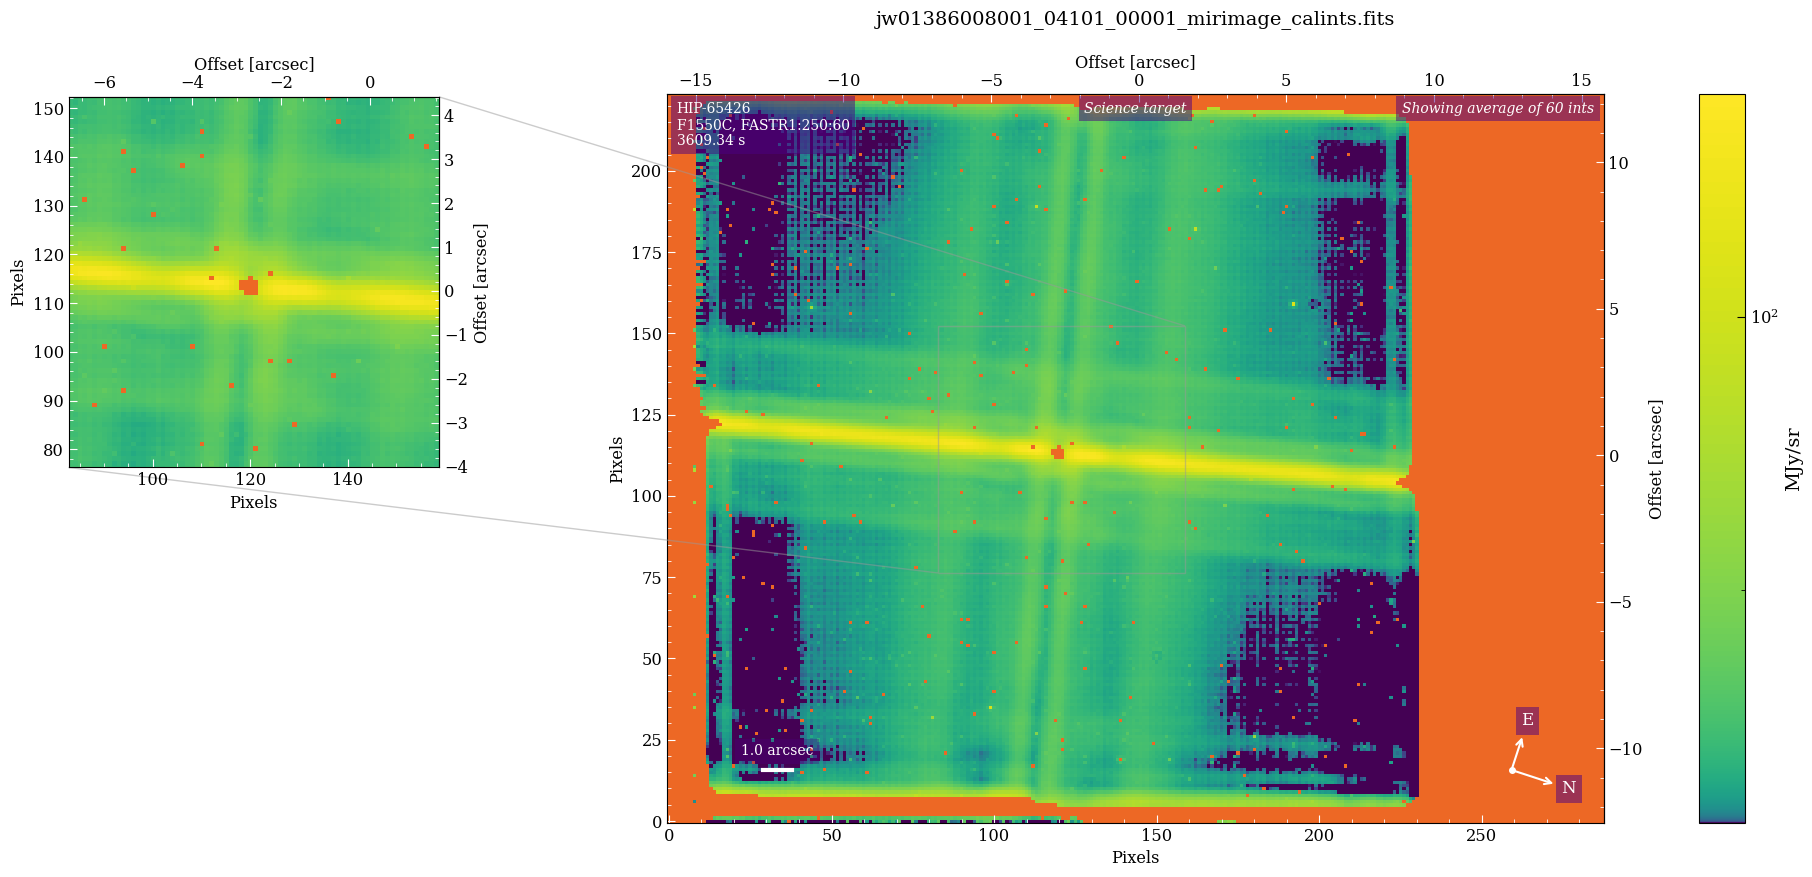

IntSlider(value=0, description='Image  Index:', max=1)

Output()

In [18]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    restrict_to={
        'FILTER': filt,  # Sort by filter.
        'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    zoom_center=3,  # Optional zoom factor; set to None to disable.
    # vmin=3, vmax=1e3,  # Define the min/max values for consistent image scaling.
    save_filename=f'{data_root}/plots_{filt}_stage2.pdf'  # Save plots to PDF.
)

---

## Stage 3 Reductions: Preparations for PSF Subtraction

As is often the case in high-contrast imaging, obtaining good PSF subtractions depends sensitively on preparing the data ahead of time.

In the following section, we improve coronagraphic reductions, taking special care with image centering, background subtraction, and bad pixel replacement/interpolation, all before the PSF subtraction steps.

---

### Optional: Re-read Stage 2 Outputs into Database
This shows how you can start re-reductions at this stage in the processing, once the previous steps have been completed.

In [19]:
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'stage2'),
                                    file_type='calints.fits',
                                    output_dir=data_root,
                                    assoc_using_targname=False,
                                    filt=filt,
                                    pid=program)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
 TYPE  EXP_TYPE DATAMODL TELESCOP ... CENTER_MASK      ROLL_REF      BLURFWHM
------ -------- -------- -------- ... ----------- ------------------ --------
   SCI MIR_4QPM   STAGE2     JWST ...   [0.0 0.0] 108.17107381748745      nan
   SCI MIR_4QPM   STAGE2     JWST ...   [0.0 0.0] 117.54983150698699      nan
SCI_BG MIR_4QPM   STAGE2     JWST ...   [0.0 0.0] 112.74286239818893      nan
SCI_BG MIR_4QPM   STAGE2     JWST ...   [0.0 0.0] 112.74285728609199      nan
REF_BG MIR_4QPM   STAGE2     JWST ...   [0.0 0.0] 112.79986264216615      nan
REF_BG MIR_4QPM   STAGE2     JWST ...   [0.0 0.0] 112.79993618079723      nan
   REF MIR_4QPM   STAGE2     JWST ...   [0.0 0.0]  109.2146450046046      nan
   REF MIR_4QPM   STAGE2     JWST ...   [0.0 0.0] 109.21463437851206      nan
   REF MIR_4QPM   STAGE2     JWST ...   [0.0 0.0] 109.2146390

---

### Using spaceKLIP ImageTools

This is where we will do some extra image processing to improve coronagraphic reductions. SpaceKLIP's image manipulation tools class, `ImageTools`, allows you to perform tasks like image alignment, bad pixel cleaning, and more directly on the data in the database.


In [20]:
# Initialize spaceKLIP image manipulation tools class.
imageTools = spaceKLIP.imagetools.ImageTools(database=database)

---

### Crop the Frames

<div class="alert alert-info">
    
**MIRI-specific Information**: This step is required only for MIRI data. </div>

As shown in the images above, the MIRI data contains regions outside the coronagraph that are not needed. To focus on the relevant coronagraphic data, we will crop the images accordingly. The `npix` parameter determines how many pixels are cropped from the edges of the frames.

In [21]:
# Crop all frames.
imageTools.crop_frames(npix=[13, 60, 7, 7],  # [left, right, bottom, top]
                       types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                       subdir='cropped')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw01386008001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame cropping: old shape = (224, 288), new shape = (210, 215)
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw01386009001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame cropping: old shape = (224, 288), new shape = (210, 215)
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw01386030001_02101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame cropping: old shape = (224, 288), new shape = (210, 215)
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw01386030001_03101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame cropping: old shape = (224, 288), new shape = (210, 215)
[spaceKLIP.imagetools:INFO]   --> Frame cropping: jw01386031001_02101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO

Let's verify the cropped images.

In [22]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 32 seconds


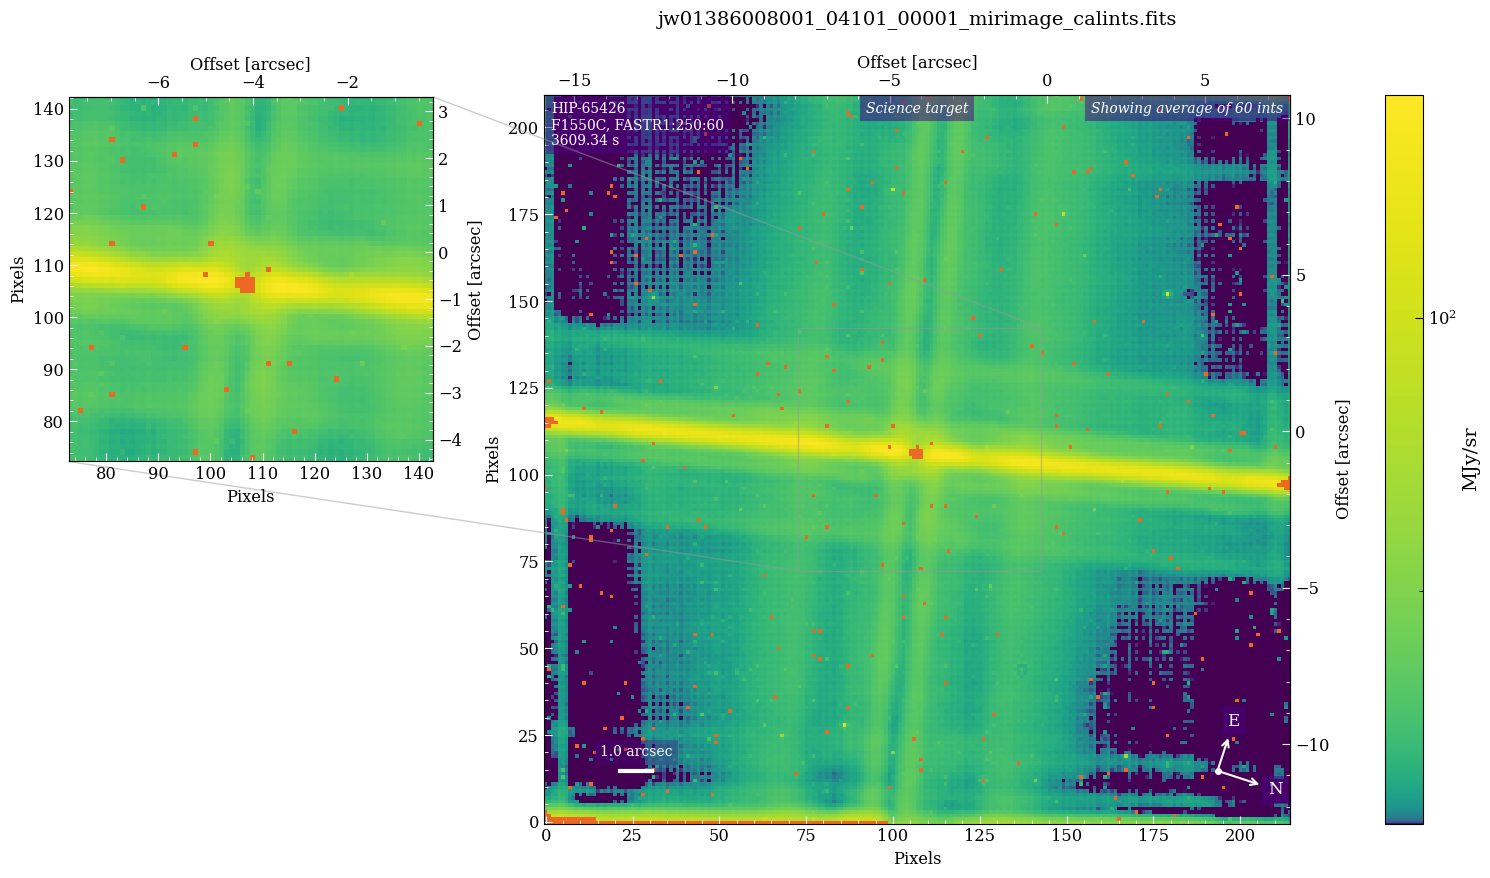

IntSlider(value=0, description='Image  Index:', max=1)

Output()

In [23]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    restrict_to={
        'FILTER': filt,  # Sort by filter.
        'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    zoom_center=3,  # Optional zoom factor; set to None to disable.
    # vmin=3, vmax=1e3,  # Define the min/max values for consistent image scaling.
    save_filename=f'{data_root}/plots_{filt}_cropped.pdf'  # Save plots to PDF.
)

---

### Find and Repair Bad Pixels

For MIRI, the JWST pipeline does not sufficiently repair bad pixels (i.e., anomalous outliers) within the coronagraphic subarrays.

Here, we use the custom functions within spaceKLIP to detect and repair these bad pixels in the following stages:
1. Clean bad pixels identified in the DQ array. 
2. Clean bad pixels using a custom mask for lingering DQ arr pixels.
3. Identify and clean bad pixels from temporal variations across integrations.
4. Identify and clean bad pixels from spatial variations. Use an iterative sigma clipping algorithm to identify additional bad pixels in the data.


In [24]:
# Fix bad pixels using custom spaceKLIP routines. Multiple routines can be
# combined in a custom order.

# ---------------------------------------------------------------
# 'dqarr': uses DQ array to identify bad pixels.
# 'interp2d': replace bad pixels with an interpolation of neighbouring pixels.
imageTools.find_bad_pixels(method='dqarr', subdir='bpfound_dq')
imageTools.clean_bad_pixels(method='interp2d',
                            interp2d_kwargs={'size': 3},
                            subdir='bpcleaned_dq')

# ---------------------------------------------------------------
# 'custom': use a custom bad pixel map.
# 'interp2d': replace bad pixels with an interpolation of neighbouring pixels.
custom_mask = {}
f1550c_coords = []
for i in list(database.obs.keys()):
    data_shape = fits.getdata(database.obs[i][0]['FITSFILE'], ext=1).shape[1:]
    custom_mask[i] = np.zeros(data_shape)
    if 'F1550C' in i:
        for coord in f1550c_coords:
            custom_mask[i][coord[1], coord[0]] = 1

imageTools.find_bad_pixels(method='custom',
                           custom_kwargs=custom_mask,
                           subdir='bpfound_custom')
imageTools.clean_bad_pixels(method='interp2d',
                            interp2d_kwargs={'size': 3},
                            subdir='bpcleaned_custom')

# ---------------------------------------------------------------
# 'timeints': identify bad pixels from temporal variations across integrations.
# 'timemed': replace pixels which are only bad in some frames with 
#            their median value from the good frames.
imageTools.find_bad_pixels(method='timeints',
                           timeints_kwargs={'sigma': 6},
                           subdir='bpfound_time')  
imageTools.clean_bad_pixels(method='timemed', subdir='bpcleaned_time')

# ---------------------------------------------------------------
# 'sigclip': use sigma clipping to identify additional bad pixels.
# 'interp2d': replace bad pixels with an interpolation of neighbouring pixels.
# 'shift_x/y': Define the range of pixel shifts (left/right and up/down)
#              used in sigma clipping to compare a pixel with its 
#              neighbors and identify deviations.
imageTools.find_bad_pixels(method='sigclip',
                           sigclip_kwargs={'sigma': 3,
                                'neg_sigma': 3,
                                'shift_x': [-2, -1, 0, 1, 2],
                                'shift_y': [-2, -1, 0, 1, 2]},
                           subdir='bpfound_sigclip')  
imageTools.clean_bad_pixels(method='interp2d',
                            interp2d_kwargs={'size': 3},
                            subdir='bpcleaned_sigclip')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386008001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386009001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386030001_02101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386030001_03101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386031001_02101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386031001_03101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386007001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386007001_04101_00002_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqarr: jw01386007001_04101_00003_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method

[spaceKLIP.imagetools:INFO]   --> Method interp2d: fixing 2736 bad pixel(s) -- 0.32%
[spaceKLIP.imagetools:INFO]   --> Method interp2d: jw01386031001_03101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method interp2d: fixing 2736 bad pixel(s) -- 0.32%
[spaceKLIP.imagetools:INFO]   --> Method interp2d: jw01386007001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method interp2d: fixing 2736 bad pixel(s) -- 0.32%
[spaceKLIP.imagetools:INFO]   --> Method interp2d: jw01386007001_04101_00002_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method interp2d: fixing 2736 bad pixel(s) -- 0.32%
[spaceKLIP.imagetools:INFO]   --> Method interp2d: jw01386007001_04101_00003_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method interp2d: fixing 2736 bad pixel(s) -- 0.32%
[spaceKLIP.imagetools:INFO]   --> Method interp2d: jw01386007001_04101_00004_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method interp2d: fixing 2736 bad pixel(s) -- 0

[spaceKLIP.imagetools:INFO]   --> Method sigclip: jw01386007001_04101_00003_mirimage_calints.fits
Frame 19/19, iteration 4
[spaceKLIP.imagetools:INFO]   --> Method sigclip: identified 7306 additional bad pixel(s) -- 0.85%
[spaceKLIP.imagetools:INFO]   --> Method sigclip: jw01386007001_04101_00004_mirimage_calints.fits
Frame 19/19, iteration 4
[spaceKLIP.imagetools:INFO]   --> Method sigclip: identified 7175 additional bad pixel(s) -- 0.84%
[spaceKLIP.imagetools:INFO]   --> Method sigclip: jw01386007001_04101_00005_mirimage_calints.fits
Frame 19/19, iteration 4
[spaceKLIP.imagetools:INFO]   --> Method sigclip: identified 7190 additional bad pixel(s) -- 0.84%
[spaceKLIP.imagetools:INFO]   --> Method sigclip: jw01386007001_04101_00006_mirimage_calints.fits
Frame 19/19, iteration 4
[spaceKLIP.imagetools:INFO]   --> Method sigclip: identified 7137 additional bad pixel(s) -- 0.83%
[spaceKLIP.imagetools:INFO]   --> Method sigclip: jw01386007001_04101_00007_mirimage_calints.fits
Frame 19/19, i

The custom mask is currently empty for this MIRI demo dataset. If you need to define one, the function `custom_bpfinder` below can help visualize the images and identify bad pixels. Note that the interactive plots require `plotly` to be installed.



In [25]:
# Helper function to identify bad pixels not found above.
def custom_bpfinder(file):

    # Check if plotly is installed.
    try:
        import plotly.graph_objects as go
    except ImportError:
        print("Plotly is not installed.")
        return

    # Load in image data.
    data = fits.getdata(file, ext=1)
    data = data if data.ndim == 2 else data[-1]

    # Generate hover text.
    hover_text = [[f"x: {x}, y: {y}, value: {data[y, x]:.2f}"
                   for x in range(data.shape[1])] for y in range(data.shape[0])]
    
    # Plot the image.
    zmin = np.nanpercentile(data, 1)
    zmax = np.nanpercentile(data, 98)
    fig = go.Figure(data=go.Heatmap(z=data, zmin=zmin, zmax=zmax,
                    hoverinfo="text", text=hover_text,
                    colorscale='Viridis', colorbar=dict(title="Pixel Value")))
    fig.update_layout(title=os.path.basename(file), 
                      xaxis_title="X (pixels)", yaxis_title="Y (pixels)",
                      width=800, height=800)
    fig.show()

# Pick a file to look at.
# custom_bpfinder(database.obs['JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550'][0]['FITSFILE'])

Again, let's examine the results, but this time focusing on the cleaned products.


In [26]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 256 seconds


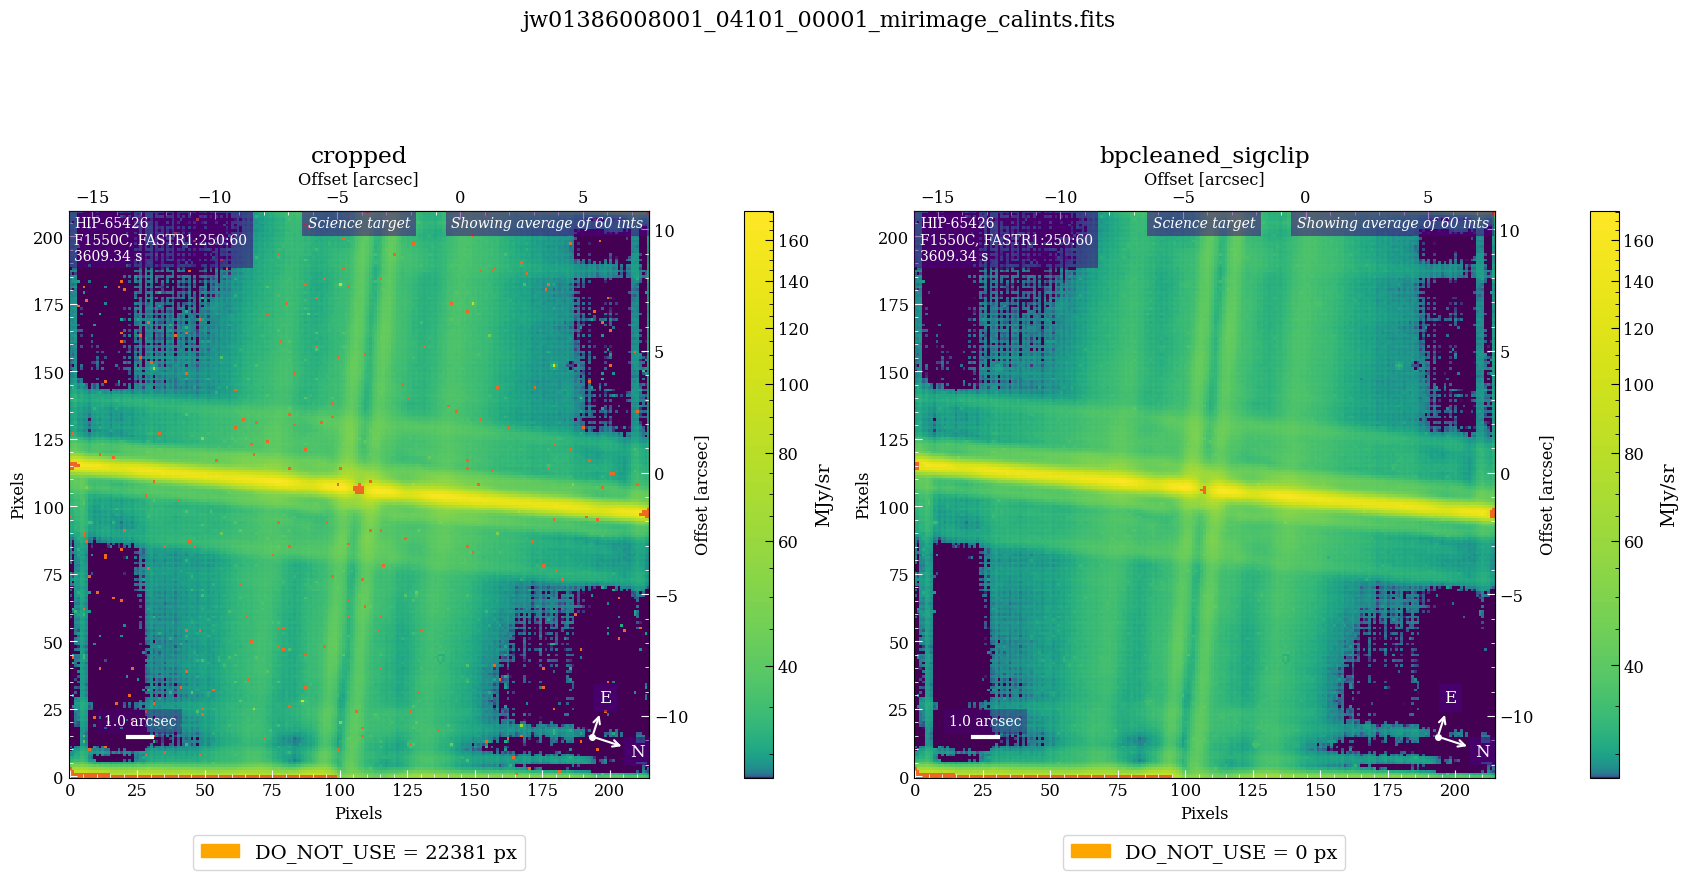

IntSlider(value=0, description='Image Index:', max=1)

Output()

In [27]:
# Compare how well each cleaning method did to replace bad pixels.

spaceKLIP.plotting.display_image_comparisons(
    database,
    ['cropped', 'bpcleaned_sigclip'],  # Subdirectories to look for files in.
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    # vmin=0, vmax=1e3, # Define the min/max values for consistent image scaling.
    save_filename=f'{data_root}/clean_bp_{filt}_comparison.pdf')

---

### Remove Background

<div class="alert alert-info">
    
**MIRI-specific Information**: MIRI flight data has revealed light scattering into the coronagraphs, creating linear features along the boundaries of the 4QPM, around the Lyot occulting spot, and near the bottom of the coronagraphic fields. The horizontal glow along the phase mask boundaries, referred to as ["glow sticks"](https://jwst-docs.stsci.edu/depreciated-jdox-articles/miri-instrument-features-and-caveats#MIRIInstrumentFeaturesandCaveats-glow_sticksGlowsticksintheMIRI4QPMcoronagraphs&gsc.tab=0), is visible in the images above. At mid-infrared wavelengths, MIRI is also highly sensitive to thermal emission from the telescope. To prevent faint sources from being obscured by scattered light and thermal emission, we perform background subtraction on the data before PSF subtraction.  </div>

SpaceKLIP's image manipulation tools class, `ImageTools`, offers two methods for background subtraction: a simple median subtraction using `subtract_background` and a more advanced technique `subtract_background_godoy` developed by Nico Godoy. 

* The `subtract_background` method performs a basic median subtraction but requires the removal of the first frame due to the reset switch charge decay (RSCD) in MIRI data, which can introduce nonlinearities at the start of integrations, non-linear ramps as the signal increases, latent images, and drifts in the slopes. Removal of the first frame can be done using `remove_frames`.

* In contrast, the `subtract_background_godoy` method refines background subtraction through an optimization process. Instead of simply subtracting the background, it analyzes specific sections of the image and adjusts the scaling to account for any residual background after the initial subtraction. This fine-tuning addresses subtle background variations, such as those caused by detector anomalies, without the need to remove the first frame.    



In [28]:
# Perform background subtraction to remove MIRI thermal background and glowstick. 
# This step is only required for MIRI.
imageTools.subtract_background_godoy(subdir='bgsub_godoy')

[spaceKLIP.imagetools:INFO]   --> Background subtraction: jw01386008001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Background subtraction: jw01386009001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Background subtraction: jw01386007001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Background subtraction: jw01386007001_04101_00002_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Background subtraction: jw01386007001_04101_00003_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Background subtraction: jw01386007001_04101_00004_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Background subtraction: jw01386007001_04101_00005_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Background subtraction: jw01386007001_04101_00006_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Background subtraction: jw01386007001_04101_00007_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Background s

Let's examine the background subtracted results.

In [29]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 260 seconds


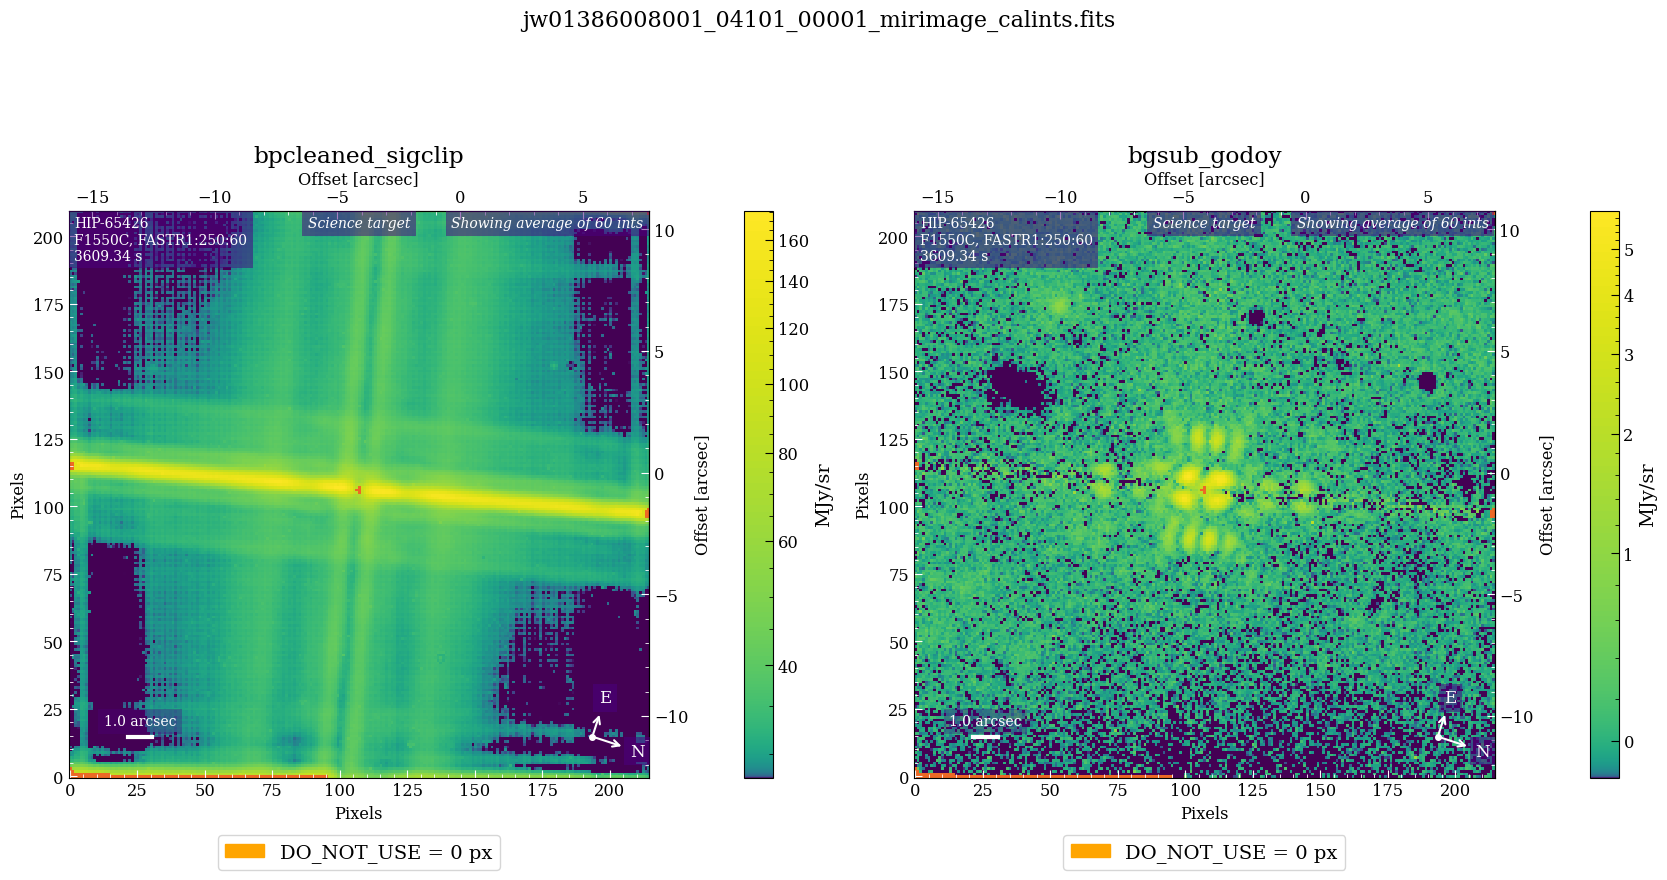

IntSlider(value=0, description='Image Index:', max=10)

Output()

In [30]:
# Examine the background subtracted images.

spaceKLIP.plotting.display_image_comparisons(
    database,
    ['bpcleaned_sigclip', 'bgsub_godoy'],  # Subdirectories to look for files in.
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI', 'REF']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    # vmin=0, vmax=500, # Define the min/max values for consistent image scaling.
    save_filename=f'{data_root}/plots_{filt}_backgroundsub.pdf')

After background subtraction, the PSF becomes much more prominent in the images. Dark regions may also appear in the images, indicating areas where sources were present in the background frames and have been subtracted.

---

### Finish Pixel Cleanup

Optionally, any remaining bad pixels can be interpolated to replace NaNs with zeros.

In this case, this step is not strictly necessary since all the bad pixels have already been addressed in the previous steps. However, running this step for example purposes will not alter any pixel values, as they have already been fixed.

In [31]:
# Replace nans.
imageTools.replace_nans(cval=0., # Fill value.
                        types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                        subdir='nanreplaced')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386008001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 7982 nan pixel(s) with value 0.0 -- 0.29%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386009001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 7980 nan pixel(s) with value 0.0 -- 0.29%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386030001_02101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 7980 nan pixel(s) with value 0.0 -- 0.29%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386030001_03101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 7980 nan pixel(s) with value 0.0 -- 0.29%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386031001_02101_00001_mirimage_calints.fits
[

---


### Improve PSF Centering and Alignment

In HCI, especially when using techniques like PSF subtraction, precise alignment of images is essential. Misalignment can introduce artifacts to the data, such as residual PSF structure and starlight, that interfere with detecting faint signals.

The alignment process for MIRI data with spaceKLIP can be broken down into the following steps: `update_miri_offsets`, `calculate_centers`, `calculate_alignment`, and `shift_frames`. 

<div class="alert alert-info">
    
**MIRI-specific Information**: This step is not intuitive. Unlike with NIRCam, the MIRI PSF structure can change in structure and appearance. This can be seen as you flip through the science and reference images above. **Attempting to align these frames may not always work.** Therefore, we skip recentering and alignment for MIRI by default. There is however, an option to use Target Acquisition (TA) data to locate the star's center for alignment purposes if needed. </div>


---

#### Update MIRI Offset Metadata

<div class="alert alert-info">

**MIRI-specific information**: The `update_miri_offsets` step is only recommended for MIRI observations taken before November 16, 2022, as those were planned with an offset in APT. This step updates the header metadata to account for the true star–coronagraph offset.

 </div>

In [32]:
imageTools.update_miri_offsets()

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
[spaceKLIP.imagetools:INFO]   --> Update MIRI coronagraphy offsets: jw01386008001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Update MIRI coronagraphy offsets: old = (0.226, 0.156), new = (0, 0)
[spaceKLIP.imagetools:INFO]   --> Update MIRI coronagraphy offsets: jw01386009001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Update MIRI coronagraphy offsets: old = (0.226, 0.156), new = (0, 0)
[spaceKLIP.imagetools:INFO]   --> Update MIRI coronagraphy offsets: jw01386007001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Update MIRI coronagraphy offsets: old = (0.226, 0.156), new = (0, 0)
[spaceKLIP.imagetools:INFO]   --> Update MIRI coronagraphy offsets: jw01386007001_04101_00002_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Update MIRI coronagraphy offsets: old = (0.216, 0.156), new = (-0.01, 1.34e-09)
[spaceKLIP.imaget

---

#### Calculate Recentering Shifts



If the recentering and alignment steps are skipped, the pipeline assumes that the STARCENX/Y values—equivalent to CRPIX1/2 in the FITS header—accurately represent the star’s position. This position is also used as the KLIP center, which serves as the reference point for PSF modeling and subtraction. For instruments like MIRI this assumption has generally worked well. 

However, if target acquisition (TA) data is available, we can obtain a more accurate estimate of the star’s location relative to the coronagraph by setting `use_ta=True`. When TA data is used, the shift needed to center the star is calculated and stored based on the following options:

1. **Default** (`first_sci_only=True`): The shift is calculated from the first SCI frame and applied to all subsequent frames, preparing them for the `calculate_alignment` step.
2. **Per-frame** (`first_sci_only=False`): The shift is calculated and stored individually to each frame. In this case, the `calculate_alignment` step should be skipped, as each frame is already centered.



This step also accounts for the coronagraph not being precisely centered in the subarray. After this step, the star center will be at the center of the pixel.

In [33]:
use_ta = False  # Use TA data for recentering?
if use_ta:
    first_sci_only = True  # Recenter based on first SCI frame?
    imageTools.calculate_centers(spectral_type='A2V', subdir='recenter_shifts', 
                                 use_ta=use_ta, first_sci_only=first_sci_only)

In [34]:
#!ls data_miri_hd65426/recenter_shifts/*pdf

In [35]:
# Open one to view the recenter of the reference images.
#!open data_miri_hd65426/recenter_shifts/*pdf

The plots output above illustrate the TA data, including the measured centroid on board (OSS) and where the WCS expects the star to be. From this data we calculate the offset needed to correct the WCS and determine the true location of the star behind the coronagraph.



---

#### Calculate Alignment Shifts

**Note: If all files were individually recentered (i.e., `first_sci_only=False` was used), skip this alignment step, as all frames should be aligned to the center.**

When recentering using the default method (`first_sci_only=True`), a constant offset is applied to each frame to center the star relative to the coronagraph mask. The offset is calculated based on the first SCI frame. As a result, the frames may not be perfectly aligned with one other, meaning the star might not occupy the exact same pixel coordinates in every frame.

To achieve precise alignment across all frames, we use the `calculate_alignment` function. This function calculates and stores the exact shifts required to align each frame with the first SCI frame (i.e., the second roll and all references are aligned to the first roll). 


In [36]:
#if use_ta and first_sci_only:
#    imageTools.calculate_alignment(method='fourier', kwargs={},
#                                   subdir='alignment_shifts',
#                                   shft_exp=0.5)

In [37]:
#!ls data_miri_hd65426/alignment_shifts/*pdf

In [38]:
# Open one to view the alignment of the reference images.
#!open data_miri_hd65426/alignment_shifts/*pdf


The plots output above illustrate the alignment corrections applied to each frame and also demonstrate the precision of the recentering process. 

* **Science Frame Alignment Plot**: This plot shows the x and y shifts in milliarcseconds (mas) for all science frames, aligned relative to the first science frame, positioned at (0, 0).
* **Reference Frame Alignment Plot**: This plot displays the x and y shifts in milliarcseconds (mas) for all reference frames (PSF references) for the specified filter. The pre-aligned centers are indicated by markers in the legend, with the post-aligned positions marked by +. 

Files with multiple integrations are aligned separately, so there may be multiple pre-aligned centers plotted.


---

### Shift Frames

Apply the shifts calculated in `calculate_centers` and `calculate_alignment` to the data.

In [39]:
#if use_ta:
#    imageTools.shift_frames(method='fourier', kwargs={}, subdir='shifted')

Now, let’s compare before and after the shift.


In [40]:
# Compare how well recentering and alignment did.
#if use_ta:
#    spaceKLIP.plotting.display_image_comparisons(
#        database,
#        ['nanreplaced', 'shifted'],  # Subdirectories to look for files in.
#        restrict_to={'FILTER': filt,  # Sort by filter.
#                     'TYPE': ['SCI', 'REF']  # Sort by file type SCI/REF.
#        },
#        subtract_first=True,  # Subtract the first science frame to check alignment.
#        interactive=True,  # Static or interactive plots?
#        # Define the min/max/stretch values for consistent image scaling.
#        # vmin=-0.5, vmax=0.5, stretch=0.05,
#        save_filename=f'{data_root}/recenter_vs_align_{filt}_comparison.pdf'
#        )

---

### Pad Empty Space Around Frames

To give space to rotate and align during pyklip. This puts a region of NAN pixels around the outside. 

In [41]:
# Pad all frames.
imageTools.pad_frames(npix=80,
                      cval=np.nan,
                      types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                      subdir='padded')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01386008001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (210, 215), new shape = (370, 375), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01386009001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (210, 215), new shape = (370, 375), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01386030001_02101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (210, 215), new shape = (370, 375), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01386030001_03101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (210, 215), new shape = (370, 375), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw013860310

---


### Coadd Frames

The test MIRI data have large number of integrations compared to NIRCam that makes the KLIP procedures, as well as proceeding contrast and companion analyses, much slower to run. To save computational time, we will coadd all of the integrations per observation. Performing such a procedure assumes that the PSF diversity with a given observation is negligible compared to the PSF diversity across multiple observations, and is generally true for JWST due to its pointing and thermal stability. Nevertheless, coadding should not be assumed as a default, and performing multiple runs with and without coadding is encouraged.

In [42]:
imageTools.coadd_frames(subdir='coadded')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
[spaceKLIP.imagetools:INFO]   --> Frame coadding: jw01386008001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame coadding: 1 coadd(s) of 60 frame(s)
[spaceKLIP.imagetools:INFO]   --> Frame coadding: jw01386009001_04101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame coadding: 1 coadd(s) of 60 frame(s)
[spaceKLIP.imagetools:INFO]   --> Frame coadding: jw01386030001_02101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame coadding: 1 coadd(s) of 60 frame(s)
[spaceKLIP.imagetools:INFO]   --> Frame coadding: jw01386030001_03101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame coadding: 1 coadd(s) of 60 frame(s)
[spaceKLIP.imagetools:INFO]   --> Frame coadding: jw01386031001_02101_00001_mirimage_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame coadding: 1 coadd(s) of 19 frame(s)
[spaceKLIP.imagetools:INFO]   --> 

---

In [43]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 270 seconds


### Display the Cleaned Datasets 

After applying all the previous steps, review the cleaned data. If you notice artifacts near bad pixels, it is likely that some were not identified and have persisted. To address this, you may need to revisit the bad pixel identification process, adjust the parameters, or add a custom bad pixel map.


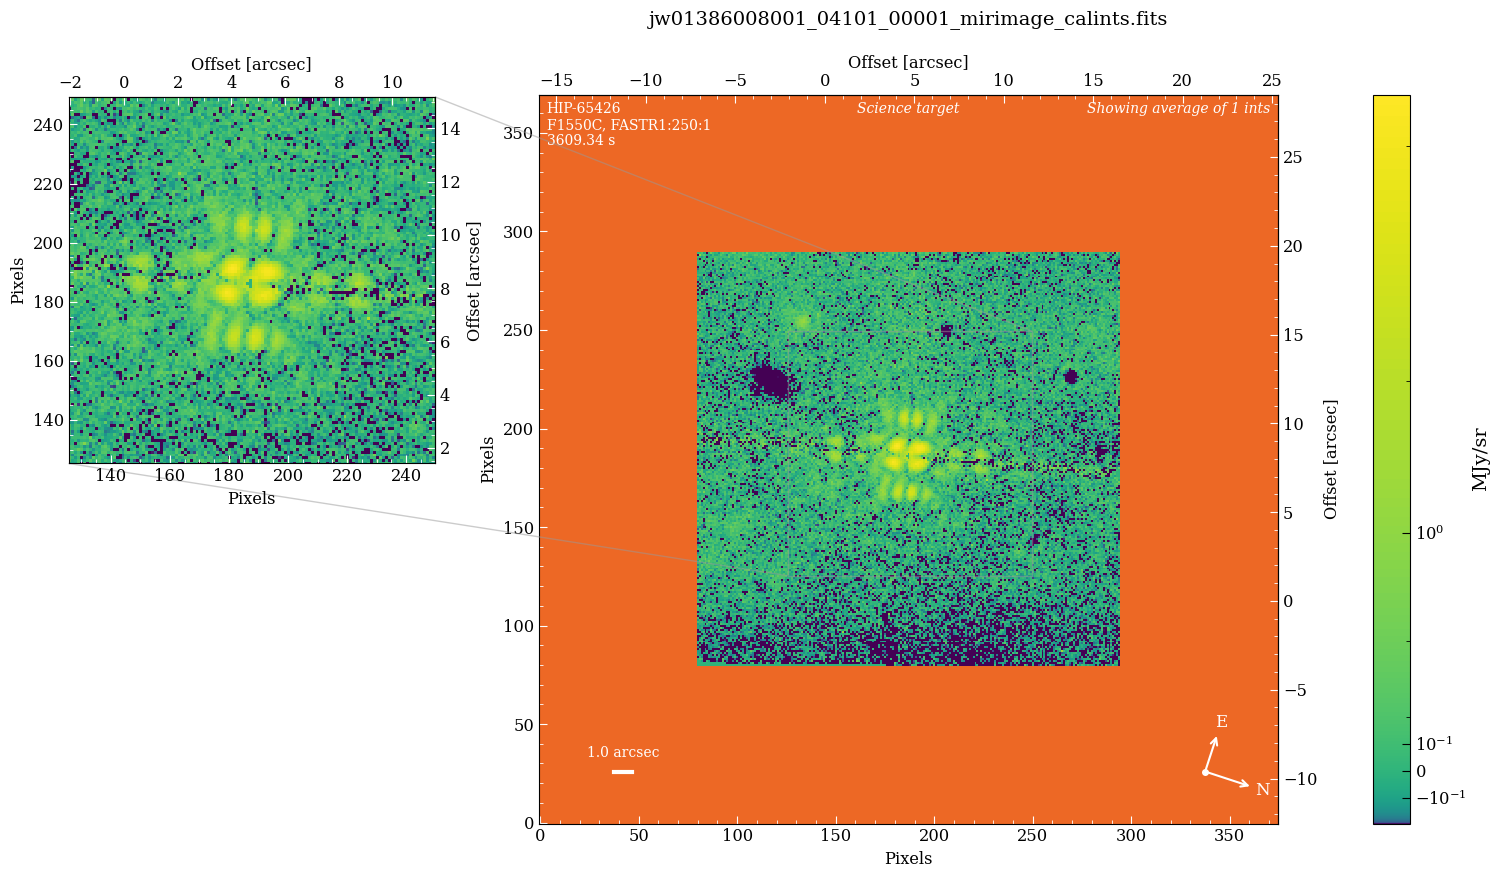

IntSlider(value=0, description='Image  Index:', max=1)

Output()

In [44]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Set to False for static plots.
    zoom_center=3,  # Optional zoom factor; set to None to disable.
    bbox_color=None,  # Remove background text boxes.
    save_filename=f'{data_root}/plots_{filt}_stage2_cleaned.pdf'  # Save plots to PDF.
)

---

## Stage 3 Reductions: KLIP

### PSF Subtraction: Option Using pyKLIP

Now that we have cleaned up our data to account for alignment and bad pixels, we are ready to perform PSF subtraction. SpaceKLIP supports several algorithms for this step, including the recommended [`pyKLIP`](https://pyklip.readthedocs.io/en/latest/index.html) and the JWST [`Coron3Pipeline`](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pipeline.Coron3Pipeline.html). In this case, we will use pyKLIP for subtraction.

You can customize the PSF subtraction process by adjusting the following settings:

> * `mode`: Choose from different image processing techniques, such as ADI, RDI, or a combination of both.
> * `annuli`: This parameter determines the number of concentric ring-shaped regions used for PSF subtraction. By specifying different numbers of annuli, you control the radial regions where the subtraction is applied, helping to remove the PSF at various distances from the center of the star. Default is [1].
> * `subsections`: This parameter defines the number of smaller regions or segments within each annulus where the PSF subtraction is applied. By breaking down the annuli into subsections, the algorithm can fine-tune the subtraction process. The default value is [1].
> * Number of KL Modes (`numbasis`): This parameter specifies how many Principal Component Analysis (PCA) modes are used to build the PSF model for subtraction. PCA modes capture different patterns and features in the data, allowing the model to represent and subtract the PSF more accurately. The default values are [1, 2, 5, 10, 20, 50, 100], which allows us to test different PSF models.
> * `algo`: Select the processing algorithm (here, klip).
> * `save_rolls`: A roll refers to a set of images taken during a specific pointing direction or orientation of the telescope. Enabling this parameter will save the PSF-subtracted versions of each individual science roll separately, in addition to the roll-combined final product.







These options help tailor the analysis to better suit your specific data and objectives.

In [45]:
# Run pyKLIP pipeline. Additional parameters for klip_dataset function can
# be passed using kwargs parameter.
spaceKLIP.pyklippipeline.run_obs(database=database,
                       kwargs={'mode': ['RDI', 'ADI+RDI'],
                               'annuli': [1],
                               'subsections': [1],
                               'numbasis': [1, 2, 5, 10, 20, 50],
                               'algo': 'klip',
                               'save_rolls': True},
                       subdir='klipsub')

[spaceKLIP.pyklippipeline:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = RDI, annuli = 1, subsections = 1
Begin align and scale images for each wavelength
Wavelength 1.552e-05 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /home/cysil/JWST/projects/Coronography/MIRI/data_miri_hd65426/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(6, 2, 1, 370, 375)
[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = ADI+RDI, annuli = 1, subsections = 1
Begin align and scale images for each wavelength
Wavelength 1.552e-05 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /home/cysil/JWST/projects/Coronography/MIRI/data_miri_hd65426/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(6, 2, 1, 370, 375)
[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
 TYPE  EXP_TYPE DATAMODL TELESCOP ... SUBSECTS    KLMODES     BUNIT  BLURFWHM
------ -------- -------- -------- ... -------- -------------- ------ --------
PYKLIP MIR_4QPM   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP MIR_4QPM   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan


The stage 3 information in the database is added to another table. The stage 2 information remains in the database, which is needed to maintain the information on rolls and references used in the reduction for forward modeling. In fact the stage 3 outputs include a JSON file that includes the table of the stage 2 data, so if you read in the stage 3 outputs it also learns about the stage 2 inputs.

In [46]:
database.summarize()

MIRI_F1550C_4QPM
	STAGE2: 15 files;	2 SCI, 9 REF, 4 BG
	STAGE3: 2 files;	2 PYKLIP


----

In [47]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 406 seconds


### Optional: Re-read Stage 3 Outputs into Database 
This shows how you can start re-analyses at this point, once you have run the previous steps.

Note, to read in stage 3 data you must set the `readlevel` parameter to 3. This invokes code for reading the stage-3 formatted data products, and also implicitly reads in the metadata about the stage 2 files used as input to stage 3. 

In [48]:
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'klipsub'),
                                    file_type='*KLmodes-all.fits',
                                    output_dir=data_root,
                                    readlevel=3,
                                    pid=program)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
 TYPE  EXP_TYPE DATAMODL TELESCOP ... SUBSECTS    KLMODES     BUNIT  BLURFWHM
------ -------- -------- -------- ... -------- -------------- ------ --------
PYKLIP MIR_4QPM   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP MIR_4QPM   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan


In [49]:
database.summarize()

MIRI_F1550C_4QPM
	STAGE2: 15 files;	2 SCI, 9 REF, 4 BG
	STAGE3: 2 files;	2 PYKLIP


---

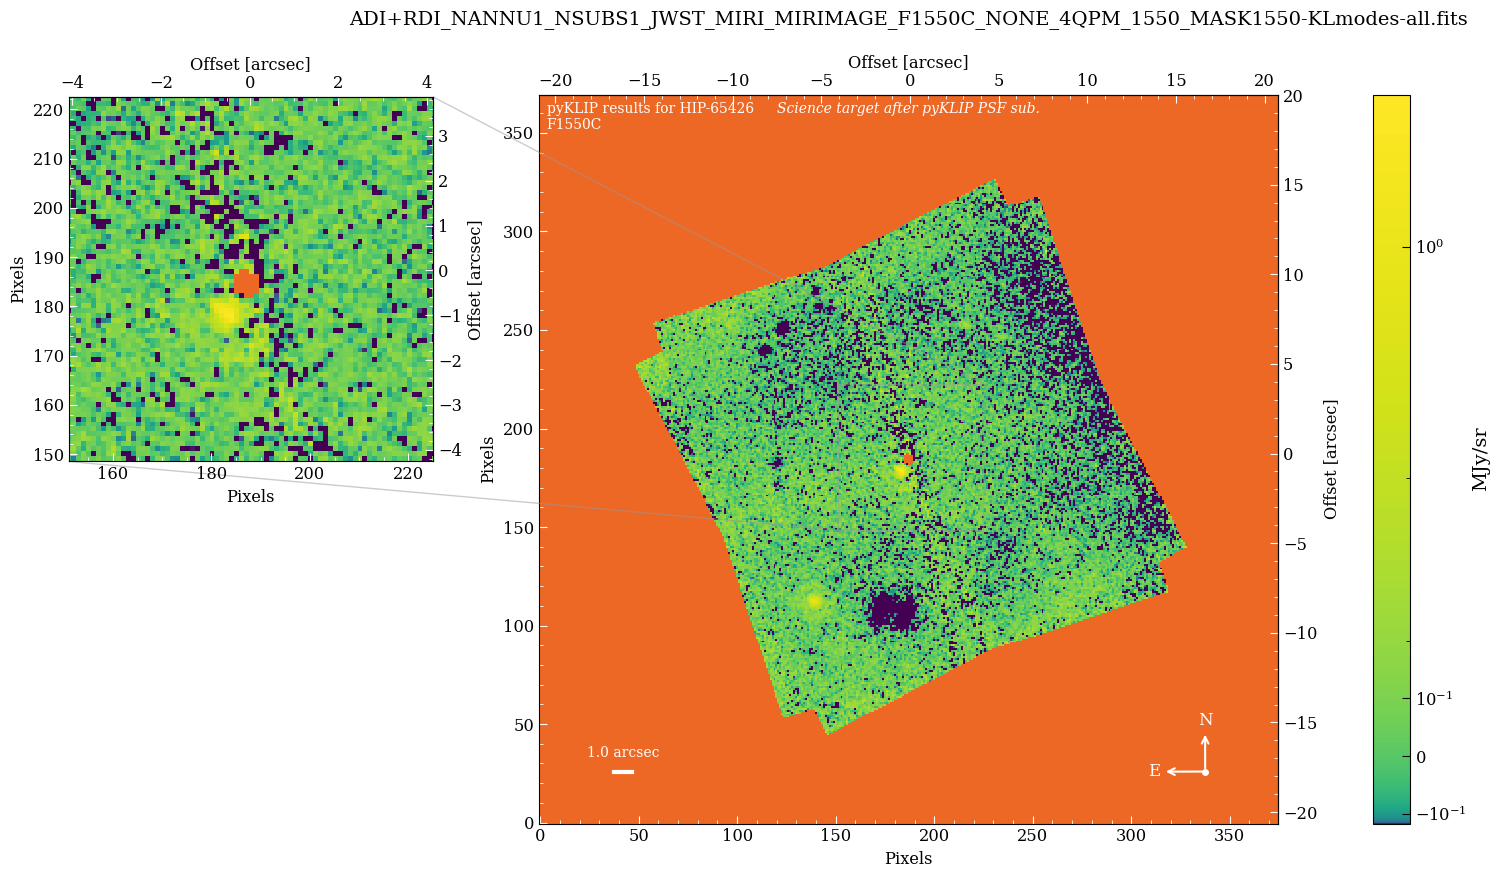

IntSlider(value=0, description='Image  Index:', max=1)

Output()

In [50]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    stage3=True,
    restrict_to=filt,  # Sort by filter.
    interactive=True,  # Static or interactive plots?
    zoom_center=5,  # Optional zoom factor; set to None to disable.
    bbox_color=None,  # Remove background text boxes.
    save_filename=f'{data_root}/plots_{filt}_pyklip.pdf'  # Save plots to PDF.
)

Hurray! We’ve reached the end of the reduction process for MIRI coronagraphic data. Now, we can move on to Part 2 of this tutorial to analyze the results. At this stage, the planet should appear to the lower left of the KLIP center (indicated by the orange point), along with other background sources. To get a closer look at the planet, consider increasing the `zoom_center` factor in the plot function above.

In [51]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 409 seconds
